# XBEACH procedural example

In this notebook we will use the rompy-xbeach and data objects to define an XBEACH workspace

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import shutil
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings("ignore")

## Workspace basepath

In [62]:
workdir = Path("example_procedural")
shutil.rmtree(workdir, ignore_errors=True)
workdir.mkdir()

## Model Grid

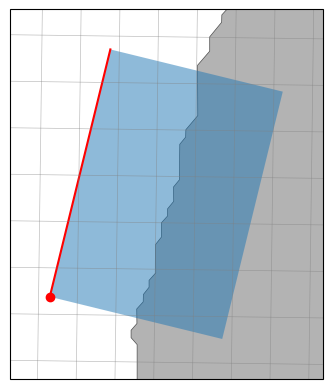

In [63]:
from rompy_xbeach.grid import RegularGrid, Ori

grid = RegularGrid(
    ori=Ori(x=115.594239, y=-32.641104, crs="EPSG:4326"),
    alfa=347.0,
    dx=10.0,
    dy=15.0,
    nx=230,
    ny=220,
    crs="EPSG:28350"
)

ax = grid.plot(scale="f")

## Work with existing data

Check the data from the rompy-xbeach tests. We will use some subset Lidar data publicly
available from the Australian Department of Transport to generate the model bathymetry

In [16]:
# Assumes rompy-xbeach is cloned at the same level as the rompy-notebooks repo
DATADIR = Path("../../../rompy-xbeach/tests/data")
display(sorted(DATADIR.glob("*")))

[PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'),
 PosixPath('../../../rompy-xbeach/tests/data/catalog.yaml')]

### Bathy


#### Inspecting the data

Load the bathy file with xarray just to inspect

In [36]:
bathyfile = DATADIR / "bathy.tif"
bathy = xr.open_dataset(bathyfile, engine="rasterio")
display(bathy)

<xarray.Dataset> Size: 130kB
Dimensions:      (band: 1, x: 176, y: 180)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 1kB 115.6 115.6 115.6 115.6 ... 115.6 115.6 115.6
  * y            (y) float64 1kB -32.65 -32.65 -32.65 ... -32.61 -32.61 -32.61
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 127kB ...

Plot the grid and bathy together

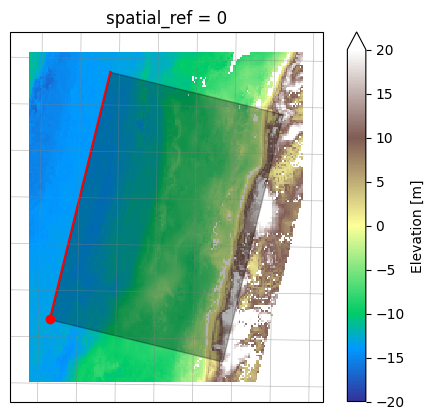

In [35]:
fig, ax = plt.subplots(figsize=None, subplot_kw=dict(projection=grid.projection))
p = bathy.band_data.isel(band=0, drop=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Elevation [m]")
)
ax = grid.plot(
    ax=ax,
    grid_kwargs=dict(facecolor="k", edgecolor="k", alpha=0.3),
)

#### Create the bathy data instance

The bathy data instance will be used to define the rompy-xbeach model config. We start
off by defining a source instance which can be passed to `XBeachBathy`. The SourceGeotiff
source can be used to handle a geotiff file

In [45]:
from rompy_xbeach.source import SourceGeotiff

source = SourceGeotiff(filename=bathyfile)
source

SourceGeotiff(model_type='geotiff', filename=PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'), band=1, kwargs={})

Then we define an interpolator instance. The interpolator takes care of the data interpolation
onto the model grid to create the model files. There is one interpolator type
`RegularGridInterpolator` currently implemented in rompy-xbeach

In [47]:
from rompy_xbeach.interpolate import RegularGridInterpolator

interpolator = RegularGridInterpolator(
    kwargs=dict(
        method="linear",
        fill_value=None,
    ),
)
interpolator

RegularGridInterpolator(model_type='scipy_regular_grid', kwargs={'method': 'linear', 'fill_value': None})

In order to allow the grid to be extended offshore so it has homogeneous depth at the
boundary, we need to specify how the extension should be performed. We do this using a
`SeawardExtension` object. A linear extension type is currently available in rompy-xbeach
which calculates the extension length based on the extension slope and depth provided,
together with the shallowest depth in the existing (non-extended) offshore boundary 

In [64]:
from rompy_xbeach.data import SeawardExtensionLinear

extension = SeawardExtensionLinear(
    depth=25,
    slope=0.1,
)
extension

SeawardExtensionLinear(model_type='linear', depth=25.0, slope=0.1)

Now we are ready to instantiate the XBeach bathy data instance, we are going to work
with `XBeachBathy` and specify the objects created above with some additional information
include posdwn (tells if depths are positive down or not) and parameters for a lateral extension

In [49]:
from rompy_xbeach.data import XBeachBathy

bathy = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
    left=5,
    right=5,
)
bathy

XBeachBathy(model_type='xbeach_bathy', id='data', source=SourceGeotiff(model_type='geotiff', filename=PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'), band=1, kwargs={}), link=False, filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=[], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth'), crop_data=True, buffer=0.0, time_buffer=[0, 0], interpolator=RegularGridInterpolator(model_type='scipy_regular_grid', kwargs={'method': 'linear', 'fill_value': None}), posdwn=False, left=5, right=5, extension=SeawardExtensionLinear(model_type='linear', depth=25.0, slope=0.1))

At this stage we are all set to define the bathymetry in the XBeach config. However it
can be useful to generate the actual bathymetry data to check and tweak if necessary

In [59]:
xfile, yfile, depfile, grid_extended = bathy.get(
    destdir=workdir,
    grid=grid,
)
print(depfile.absolute())

/source/csiro/rompy-notebooks/notebooks/xbeach/example_procedural/bathy.txt


The xbeach accessor provides methods to create a Dataset from the datafiles and plot them

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 230, x: 242)
Coordinates:
    xc           (y, x) float64 445kB 3.68e+05 3.68e+05 ... 3.711e+05 3.711e+05
    yc           (y, x) float64 445kB 6.388e+06 6.388e+06 ... 6.39e+06 6.39e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    dep          (y, x) float64 445kB -25.0 -24.01 -23.02 ... 14.63 14.45 14.53

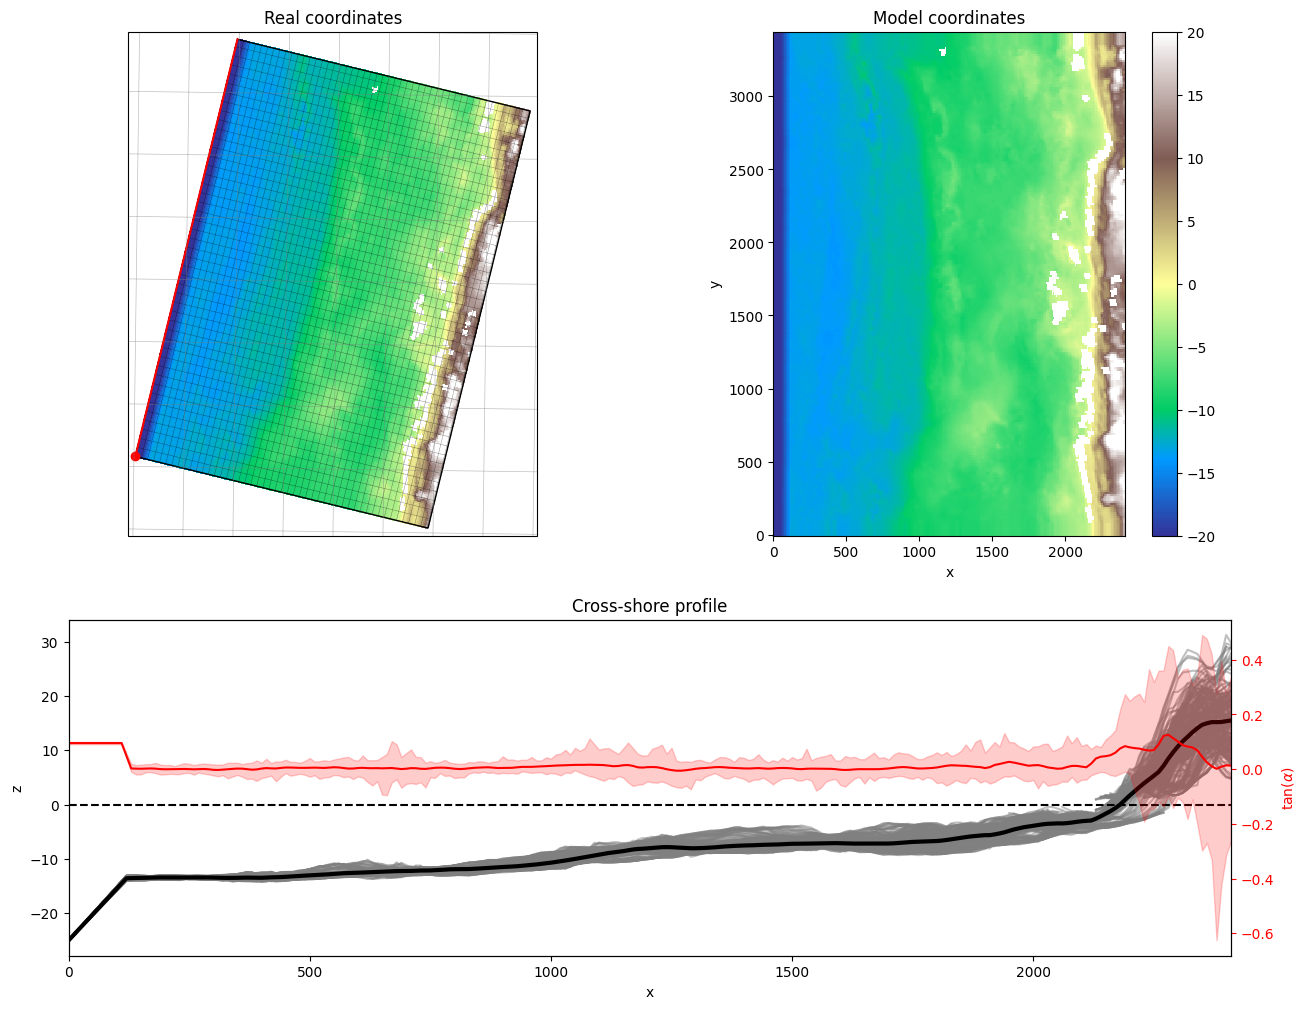

In [61]:
dset = xr.Dataset.xbeach.from_xbeach(depfile, grid_extended)
display(dset)
dset.xbeach.plot_model_bathy(grid_extended, posdwn=False)

### Times

The rompy `TimeRange` is not yet integrated in the XBeach config object but it will be
used to select boundary conditions from the data. It is currently not clear if / how we
should use it to define the model computation times (`tstart`, `tstop`, `tint`)

In [13]:
from rompy.core.time import TimeRange

In [14]:
# Define a time object to run the model in surfbeat mode for 1800 s

times = TimeRange(
    start="2024-10-15T00:00",
    end="2024-10-15T00:30",
    interval="1800s")
times

TimeRange(start=datetime.datetime(2024, 10, 15, 0, 0), end=datetime.datetime(2024, 10, 15, 0, 30), duration=datetime.timedelta(seconds=1800), interval=datetime.timedelta(seconds=1800), include_end=True)

## XBEACH parameters

The grid and bathy data objects created above are used in the XBeach Config object
to define the required parameters defined in those objects. The other model parameters
are specified directly by fields in the Config class which define available options for
these parameters where appropriate

In [65]:
from rompy_xbeach.config import Config

Config?

Init signature:
Config(
    *,
    model_type: Literal['xbeach'] = 'xbeach',
    template: str = '/source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base',
    checkout: Optional[str] = 'main',
    grid: rompy_xbeach.grid.RegularGrid,
    bathy: rompy_xbeach.data.XBeachBathy,
    front: Literal['abs_1d', 'abs_2d', 'wall', 'wlevel', 'nonh_1d', 'waveflume'] = 'abs_2d',
    back: Literal['wall', 'abs_1d', 'abs_2d', 'wlevel'] = 'abs_2d',
    left: Literal['neumann', 'wall', 'no_advec', 'neumann_v', 'abs_1d'] = 'neumann',
    right: Literal['neumann', 'wall', 'no_advec', 'neumann_v', 'abs_1d'] = 'neumann',
    rugdepth: typing.Annotated[float, Ge(ge=0.0), Le(le=1.0)],
    tunits: str = 's',
    instat: int,
    breaker: int,
    scheme: int,
    order: Literal[1, 2] = 2,
    leftwave: Literal['neumann', 'wavecrest', 'cyclic'] = 'neumann',
    rightwave: Literal['neumann', 'wavecrest', 'cyclic'] = 'neumann',
    random: Literal[0, 1] = 1,
    windfile: str,
    zs0file: str,
    tidelen: 

### Instantiate the XBeach config

In [66]:
config = Config(
    grid=grid,
    bathy=bathy,
    front="abs_2d",
    back="abs_2d",
    left="neumann",
    right="neumann",
    rugdepth=0.011,
    tunits="seconds since 1970-01-01 00:00:00.00 +00",
    instat=41,
    breaker=1,
    scheme=1,
    order=1,
    leftwave="wavecrest",
    rightwave="wavecrest",
    random=1,
    windfile="wind.txt",
    zs0file="zs0input.txt",
    tidelen=49,
    tideloc=1,
    zs0=0.0,
    hmin=0.01,
    wci=0,
    alpha=1,
    delta=0.0,
    n=10,
    rho=1025,
    g=9.81,
    thetamin=-80,
    thetamax=80,
    dtheta=10.0,
    beta=0.1,
    roller=1,
    gamma=0.55,
    gammax=1.0,
    bcfile="jonswap.txt",
    sedtrans=0,
    morfac=0.0,
    morphology=0,
    cf=0.01,
    paulrevere=0,
    eps=0.01,
    epsi=0.001,
    tstart=0,
    tint=3600,
    tstop=86400,
    cfl=0.8,
    umin=0.1,
    oldhu=1,
    outputformat="netcdf",
    ncfilename="xboutput_test.nc",
    tintm=3600,
    nmeanvar=14,
)
config

Config(model_type='xbeach', template='/source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base', checkout='main', grid=RegularGrid(ori=Ori(x=115.594239, y=-32.641104, crs='EPSG:4326'), alfa=347.0, dx=10.0, dy=15.0, nx=230, ny=220, crs='EPSG:28350'), bathy=XBeachBathy(model_type='xbeach_bathy', id='data', source=SourceGeotiff(model_type='geotiff', filename=PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'), band=1, kwargs={}), link=False, filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=[], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth'), crop_data=True, buffer=0.0, time_buffer=[0, 0], interpolator=RegularGridInterpolator(model_type='scipy_regular_grid', kwargs={'method': 'linear', 'fill_value': None}), posdwn=False, left=5, right=5, extension=SeawardExtensionLinear(model_type='linear', depth=25.0, slope=0.1)), front='abs_2d', back='abs_2d', left='neumann', right='neumann', rugdepth=0.011, tunits='seconds since 1970-

### Generate workspace

In [67]:
from rompy.model import ModelRun

run = ModelRun(
    run_id="run1",
    period=times,
    output_dir=str(workdir),
    config=config,
)

rundir = run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: run1
period: 
	Start: 2024-10-15 00:00:00
	End: 2024-10-15 00:30:00
	Duration: 0:30:00
	Interval: 0:30:00
	Include End: True

output_dir: example_procedural
config: <class 'rompy_xbeach.config.Config'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example_procedural
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in example_procedural
INFO:rompy.model:-----------------------------------------------------


### Check the workspace

In [68]:
modeldir = Path(run.output_dir) / run.run_id

sorted(modeldir.glob("*"))

[PosixPath('example_procedural/run1/bathy.txt'),
 PosixPath('example_procedural/run1/input'),
 PosixPath('example_procedural/run1/output'),
 PosixPath('example_procedural/run1/params.txt'),
 PosixPath('example_procedural/run1/xdata.txt'),
 PosixPath('example_procedural/run1/ydata.txt')]

In [69]:
params = modeldir / "params.txt"
print(params.read_text())

#
# XBEACH - Simple example template used by rompy
# Template: /source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base
# Generated: 2024-10-15 02:26:45.434472 on rafael-XPS by rguedes
#

###########################################################################
#                               MODEL GRID                                #
###########################################################################

nx           = 242
ny           = 230
dx           = 10.0
dy           = 15.0
xori         = 368011.2066131959
yori         = 6387580.505638544
alfa         = 347.0
projection   = +proj=utm +zone=50 +south +ellps=GRS80 +units=m +no_defs +type=crs
rugdepth     = 0.011
tunits       = seconds since 1970-01-01 00:00:00.00 +00
thetamin     = -80.0
thetamax     = 80.0
dtheta       = 10.0

###########################################################################
#                               MODEL TIME                                #
###########################################

## Run the model

To be implemented

In [70]:
# !docker run  -v ./example_procedural/run1:/home rom-py/xbeach:dev params.txt > example_procedural/xbeach.log
# !tail example_procedural/xbeach.log

## Plot outputs

To be implemented

## Cleanup

Uncomment below to clean up the test workspace directory

In [78]:
# import shutil

# shutil.rmtree(workdir, ignore_errors=True)